In [1]:
import json
import glob
import os

from sklearn import model_selection
from sklearn import datasets
from sklearn import svm
from sklearn.metrics.pairwise import cosine_similarity

import scipy.special
from scipy.stats import hypergeom

import numpy as np

import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.multiprocessing as multiprocessing

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.datasets as dset

from PIL import Image

import feature_extractor

import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
extractor = feature_extractor.YouTube8MFeatureExtractor()
stl10_train = dset.STL10('.', split='train', download=True)
STL_CLASS_PATH = './stl10_binary/class_names.txt'
def get_stl_class_list(path):
    with open(path, 'r') as f:
        labels = f.readlines()
        return list(map(lambda x:x.strip('\n'), labels))

stl_label_names = get_stl_class_list(STL_CLASS_PATH)


Files already downloaded and verified


In [3]:
D_in = 1024
D_out = 128

simple_model = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
    torch.nn.Tanh()
)


# middle_model = torch.nn.Sequential(
#     torch.nn.Linear(D_in, 256),
#     torch.nn.Tanh(),
#     torch.nn.Linear(256, D_out)
#     torch.nn.Tanh()
# )


# fancy_model = torch.nn.Sequential(
#     torch.nn.Linear(D_in, 512),
#     torch.nn.SELU(),
#     torch.nn.Linear(512, 256),
#     torch.nn.SELU(),
#     torch.nn.Linear(256, D_out),
#     torch.nn.Tanh()
# )

# fancy_tan_model = torch.nn.Sequential(
#     torch.nn.Linear(D_in, 512),
#     torch.nn.Tanh(),
#     torch.nn.Linear(512, 256),
#     torch.nn.Tanh(),
#     torch.nn.Linear(256, D_out),
#     torch.nn.Tanh()
# )


choose_model  = simple_model

In [4]:
def makeplots(x0, y0, use_imshow=True):
    figs = []
    axs = []
    fmtoptions = 'ro'
    
    
    fig, ax = plt.subplots(figsize=(15,10))
    figs.append(fig)
    axs.append(ax)

    print('x')
    if use_imshow:
        ax.imshow(x0)
    else:
        ax.plot(np.arange(x0.shape[1]), x0.flatten())
        
    x0_proj = np.sum(x0, axis=0)/x0.shape[0]
    fig, ax = plt.subplots(figsize=(15,10))
    ax.plot(x0_proj, fmtoptions)
    figs.append(fig)
    axs.append(ax)

    fig, ax = plt.subplots(figsize=(15,10))
    hh = np.histogram(x0,bins=255)
    #ax.plot(hh[1][:-1], np.log10(hh[0]), fmtoptions)
    #ax.hist(np.log(hh[0]), bins = hh[1])
    ax.plot(hh[1][:-1], hh[0], fmtoptions)
    figs.append(fig)
    axs.append(ax)

    print('y')
    fig, ax = plt.subplots(figsize=(15,10))
    if use_imshow:
        ax.imshow(y0)
    else:
        ax.plot(np.arange(y0.shape[1]), y0.flatten())
        
    #ax.imshow(y0)
    figs.append(fig)
    axs.append(ax)

    y0_proj = np.sum(y0, axis=0)/y0.shape[0]
    fig, ax = plt.subplots(figsize=(15,10))
    ax.plot(y0_proj, fmtoptions)
    figs.append(fig)
    axs.append(ax)

    fig, ax = plt.subplots(figsize=(15,10))
    hh = np.histogram(y0,bins=255)
    #ax.plot(hh[1][:-1], np.log10(hh[0]), fmtoptions)
    #ax.hist(np.log(hh[0]), bins = hh[1])
    ax.plot(hh[1][:-1], hh[0], fmtoptions)
    figs.append(fig)
    axs.append(ax)

    
    return figs, axs

def getBaseStats(sflist, label):
    sfbaseline = [os.path.basename(x) for x in sflist]
    decksize = len(sfbaseline)
    numlabels = np.sum([x.find(label) != -1 for x in sfbaseline])
        
    return decksize, numlabels

def expectedNumByHand(sflist, label, size):
    '''
    computes the expected number of sound files in a random draw without replacement
    
    sflist - list of sound files
    label - label to match to name of soundfiles
    size - size of the draw
    '''
    
    decksize, numlabels = getBaseStats(sflist, label)
    remainder = decksize - numlabels
    
    expectation_value = 0
    for i in range(1, size+1):
        expectation_value += i * scipy.special.comb(remainder,size-i, exact=True) * scipy.special.comb(numlabels,i, exact=True)

    return expectation_value / scipy.special.comb(decksize,size, exact=True)

def getProbs(sflist, label, size):
    
    decksize, numlabels = getBaseStats(sflist, label)
    
    hyperfun = hypergeom(decksize, numlabels, size)
    return hyperfun.pmf(np.arange(0,size+1))
    

def expectedNum(sflist, label, size):
    '''
    computes the expected number of sound files in a random draw without replacement
    
    sflist - list of sound files
    label - label to match to name of soundfiles
    size - size of the draw
    '''
    
    return np.sum([(i)*p for i,p in enumerate(getProbs(sflist, label, size))]) 

def expectedNumSq(sflist, label, size):
    '''
    computes the expected number^2 of sound files in a random draw without replacement
    
    can use to compute the variance = expectedNumSq - expectedNum^2
    sflist - list of sound files
    label - label to match to name of soundfiles
    size - size of the draw
    '''
    
    return np.sum([(i)**2*p for i,p in enumerate(getProbs(sflist, label, size))]) 

def plot_image(imgfile):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(imgfile)
    del fig
    del ax
    
def predict_audio(imgfile, video_range = 2.0):
    feat = extractor.extract_rgb_frame_features(np.array(imgfile))
    feat = clip_n_scale(feat, -video_range, video_range)
    feat = feat[np.newaxis,:]
    #describe(feat)
    audio_pred = choose_model(torch.from_numpy(feat)).detach().numpy()
    sfsims = _calcCosSim( audio_pred )
    sfsims.sort(key = lambda x:x[1], reverse=True)
    sfsims = list(sfsims)
    
    return sfsims, feat, audio_pred

def numlabel_match(soundfilelist, imglabel):
    return [[x[0], int(x[0].find(imglabel) != -1)] for x in soundfilelist]


def _calcCosSim(audio_features):
    sf_similarities = []
    for k,v in _SOUNDFILE_FEATURES.items():
        mean_audio = np.array(v['mean_audio']).reshape(1,-1)
        cossim = cosine_similarity(audio_features, mean_audio)
        sf_similarities.append((v['filename'], cossim[0][0], k))
    return sf_similarities

def clip_n_scale(features, min_value=-2.0, max_value=2.0):
  assert features.dtype == 'float32'
  features = np.clip(features, min_value, max_value)
  _range = (max_value - min_value)/2.
  return features / _range

In [5]:
choose_model.load_state_dict(torch.load('simple_model_jun21.pt'))
choose_model.eval()

Sequential(
  (0): Linear(in_features=1024, out_features=128, bias=True)
  (1): Tanh()
)

In [6]:
#Have model and feature extractor set up. Have STL10 data loaded
#Now get 500 animals and compare against random sampling

test_animals = ['horse', 'dog', 'cat']

animal_indexes = {}
num_samples = 500

for animal in test_animals:
    i = 0
    index_list = []
    while len(index_list) < num_samples:
        ex = stl10_train[i]
        if ex[1] == stl_label_names.index(animal):
            index_list.append(i)

        i += 1
    animal_indexes[animal] = index_list

In [7]:
len(animal_indexes['horse'])

500

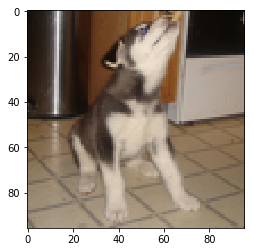

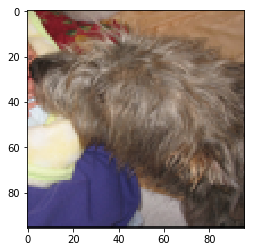

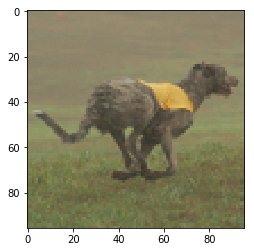

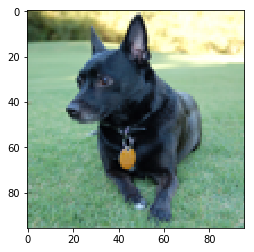

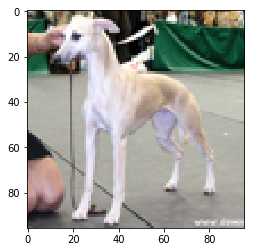

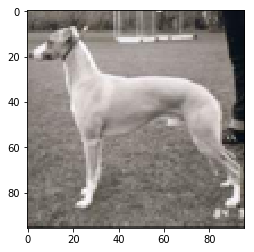

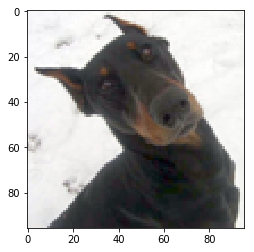

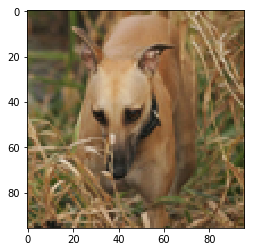

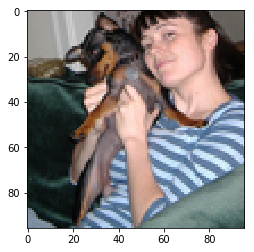

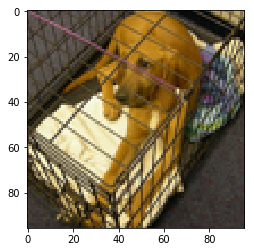

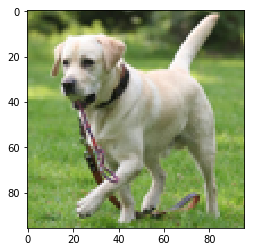

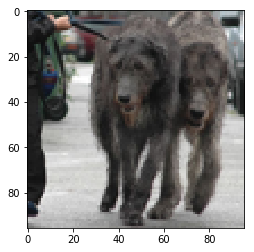

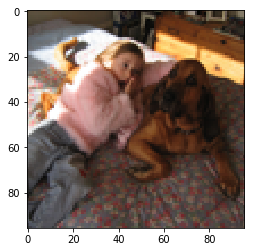

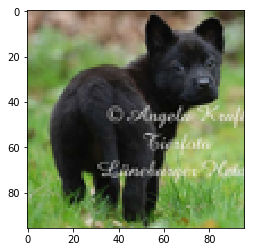

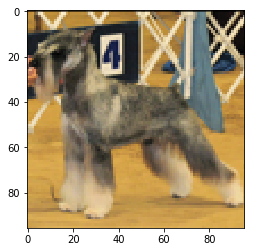

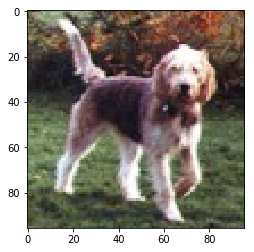

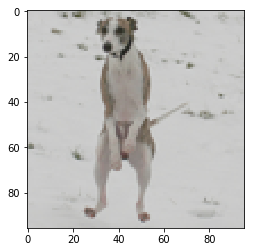

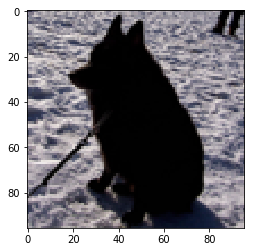

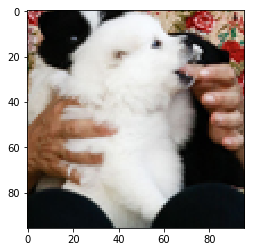

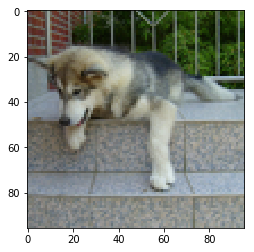

In [8]:
_thisanimal = 'dog'

for i in range(50,70):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(stl10_train[animal_indexes[_thisanimal][i]][0])
    del fig
    del ax

In [9]:
soundeffectfiles = glob.glob('../data/soundeffectfiles/features/*.json')
print(len(soundeffectfiles))
sfbasename = [os.path.basename(x) for x in soundeffectfiles]

_SOUNDFILE_FEATURES = {}
for sf in soundeffectfiles:
    sfdict = json.load(open(sf,'r'))
    _SOUNDFILE_FEATURES[sf] = sfdict

72


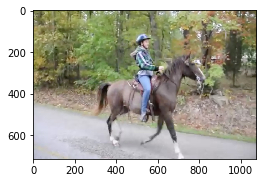

In [10]:
imgfile = Image.open('/Users/adam/Desktop/horse.jpg')

sfsims, vid_feat, audio_feat = predict_audio(imgfile)
plot_image(imgfile)


In [11]:
matches = numlabel_match(sfsims,'horse')

In [12]:
np.array(matches)[:10]

array([['one_horse_walking_tarmac.wav', '1'],
       ['horse_trotting_rough_track.wav', '1'],
       ['two_horses_trot_past_on_tarmac.wav', '1'],
       ['horse_trotting_rough_track_stop_depart.wav', '1'],
       ['pig.wav', '0'],
       ['horse_gallops_past_on_field.wav', '1'],
       ['geiger_counter.wav', '0'],
       ['polar_bear_2.wav', '0'],
       ['goat.wav', '0'],
       ['mitch-pigeon.wav', '0']], dtype='<U42')

In [13]:
np.sum(np.array(matches)[:5,1].astype(int))

4

In [14]:
results = []
topN = 5
top_N_results = {}
for animal_label in test_animals:
    print(animal_label)
    num_top_N = []
    for animal_index in animal_indexes[animal_label]:
        sfsims, _, _ = predict_audio(stl10_train[animal_index][0])
        matches = numlabel_match(sfsims,animal_label)
        num_top_N.append(np.sum(np.array(matches)[:topN,1].astype(int)))
        
    expValue = expectedNum(soundeffectfiles, animal_label, topN)
    expValueSq = expectedNumSq(soundeffectfiles, animal_label, topN)
    
    expStdDev = np.sqrt(expValueSq - expValue**2)
    top_N_results[animal_label] = num_top_N
    results.append([animal_label, np.mean(num_top_N), 
                    np.sqrt( np.std(num_top_N) )/np.sqrt(len(num_top_N)), 
                    np.sqrt( np.mean(num_top_N) )/np.sqrt(len(num_top_N)), 
                    expValue, expStdDev ])

horse
dog
cat


In [18]:
print('the std of the expected number by random are poisson')
for rr in results:
    print('{}: {:.2f} +- {:.2f} (sqrt(mean): {:.2f})  --> {:.2f} +- {:.2f}'.format(*rr))

the std of the expected number by random are poisson
horse: 1.32 +- 0.05 (sqrt(mean): 0.05)  --> 0.42 +- 0.60
dog: 1.09 +- 0.04 (sqrt(mean): 0.05)  --> 0.28 +- 0.50
cat: 0.77 +- 0.04 (sqrt(mean): 0.04)  --> 0.49 +- 0.64


In [51]:
for animal in test_animals:
    print(animal)
    num_animals = np.array(top_N_results[animal])
    print("{}    --> {}".format(0, (num_animals == 0).sum()/len(num_animals)))
    for i in range(1,6):  
      print("{} or more --> {}".format(i,(num_animals >= i).sum()/len(num_animals)))

horse
0    --> 0.47
1 or more --> 0.53
2 or more --> 0.412
3 or more --> 0.256
4 or more --> 0.122
5 or more --> 0.0
dog
0    --> 0.264
1 or more --> 0.736
2 or more --> 0.35
3 or more --> 0.0
4 or more --> 0.0
5 or more --> 0.0
cat
0    --> 0.404
1 or more --> 0.596
2 or more --> 0.164
3 or more --> 0.006
4 or more --> 0.0
5 or more --> 0.0


In [66]:
getProbs(soundeffectfiles, 'cat', 5)[2:].sum()

0.07092683981124594

In [15]:
getBaseStats(soundeffectfiles, "cat")

(72, 7)

In [16]:
getBaseStats(soundeffectfiles, "dog")

(72, 4)

(array([235.,  59.,  78.,  67.,  61.,   0.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

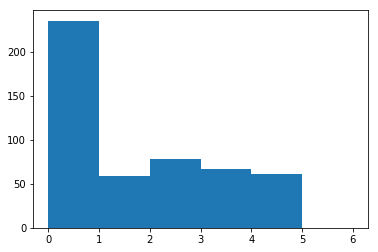

In [17]:
plt.hist(top_N_results['horse'],bins=[0,1,2,3,4,5,6])

(array([132., 193., 175.,   0.,   0.,   0.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

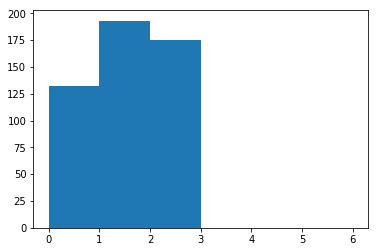

In [19]:
plt.hist(top_N_results['dog'],bins=[0,1,2,3,4,5,6])

(array([202., 216.,  79.,   3.,   0.,   0.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

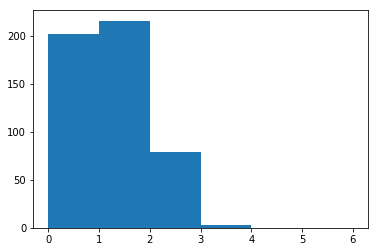

In [20]:
plt.hist(top_N_results['cat'],bins=[0,1,2,3,4,5,6])

In [21]:
## To do a REAL random comparions study, need to randomly 
## generate 128-length audio vectors and then find top five matches(?)
   # or, would I put in a random input video vector, then measure the 
   # distribution of selected sound files that emerge? 
    


In [22]:
## Compare the pig.wav file to the 
#pig.wav: soundeffectfiles[-6]
#one_horse_tarmac.wav: soundeffectfiles[37]
#goat.wav: soundeffectfiles[-9]

In [23]:
Y_pig_median = _SOUNDFILE_FEATURES[soundeffectfiles[-6]]['median_audio']

Y_one_horse_median = _SOUNDFILE_FEATURES[soundeffectfiles[37]]['median_audio']

Y_goat_median = _SOUNDFILE_FEATURES[soundeffectfiles[-9]]['median_audio']

In [24]:
Y_pig = _SOUNDFILE_FEATURES[soundeffectfiles[-6]]['audio']

Y_one_horse = _SOUNDFILE_FEATURES[soundeffectfiles[37]]['audio']

Y_goat = _SOUNDFILE_FEATURES[soundeffectfiles[-9]]['audio']

In [25]:
type(Y_goat)

list

x
y


([<Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>],
  <matplotlib.axes._subplots.AxesSubplot at 0x1a2f0a1978>])

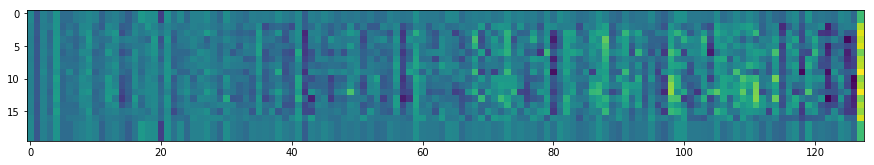

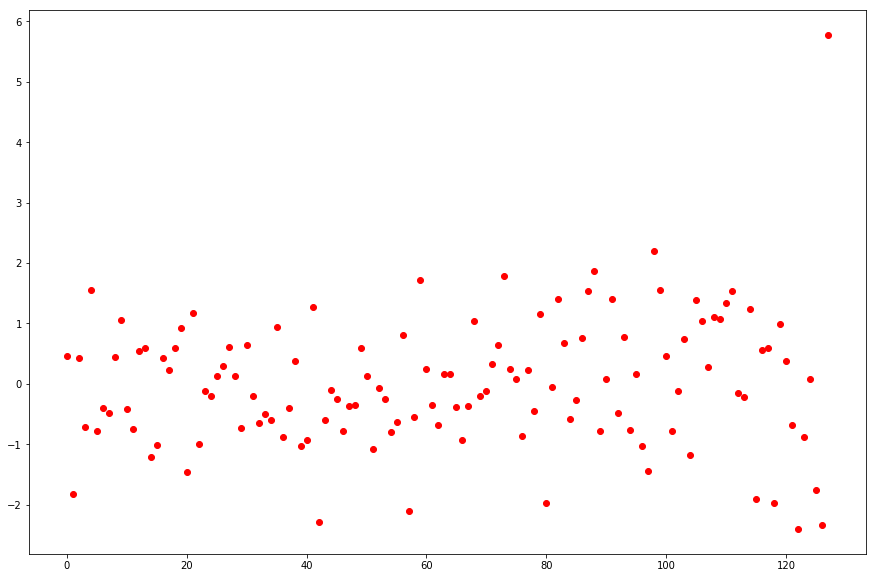

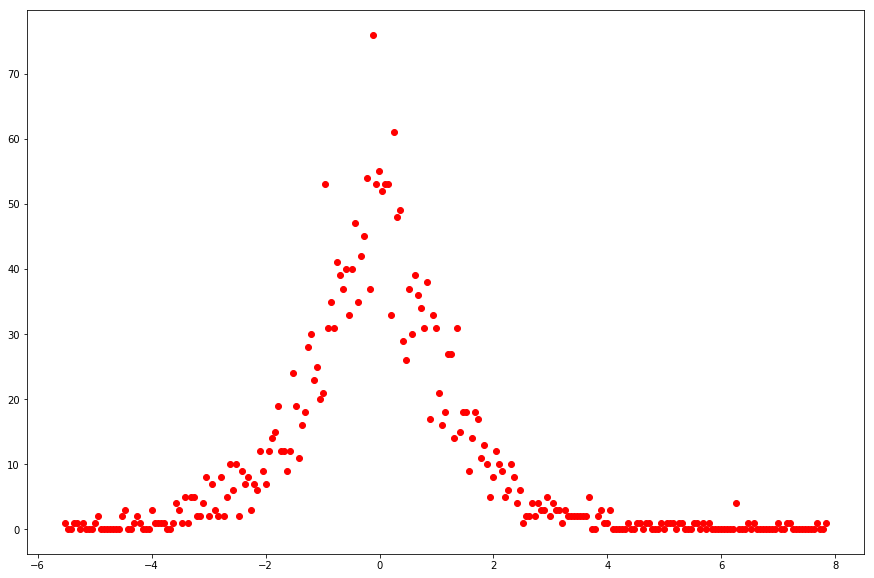

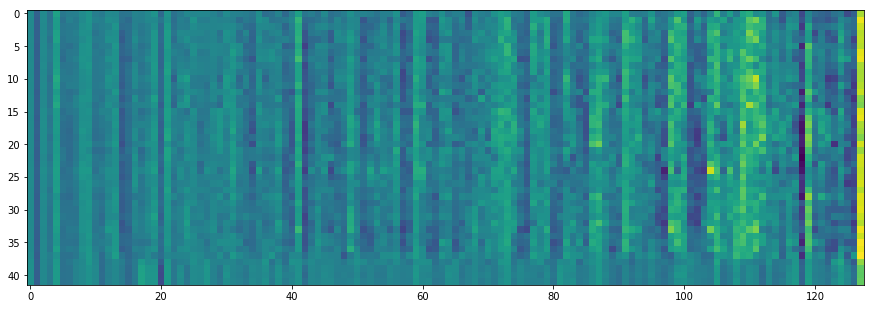

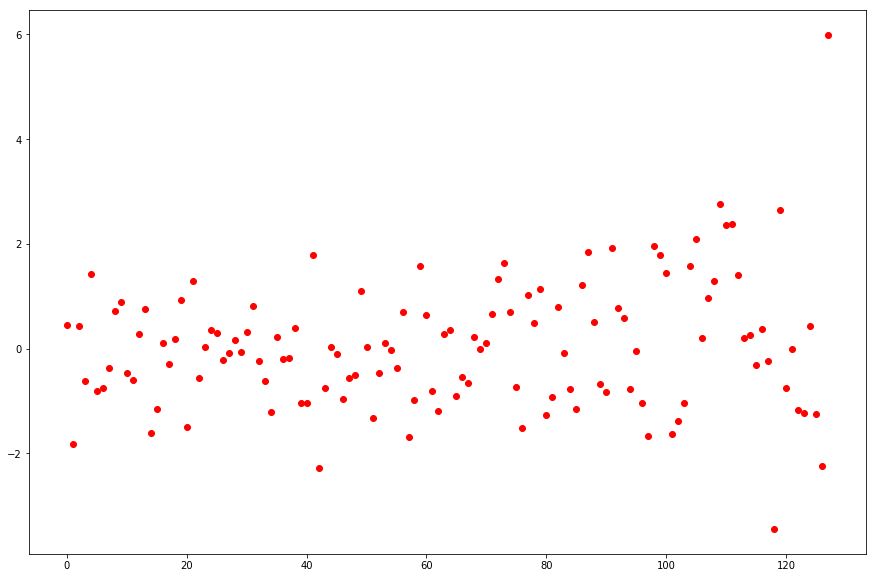

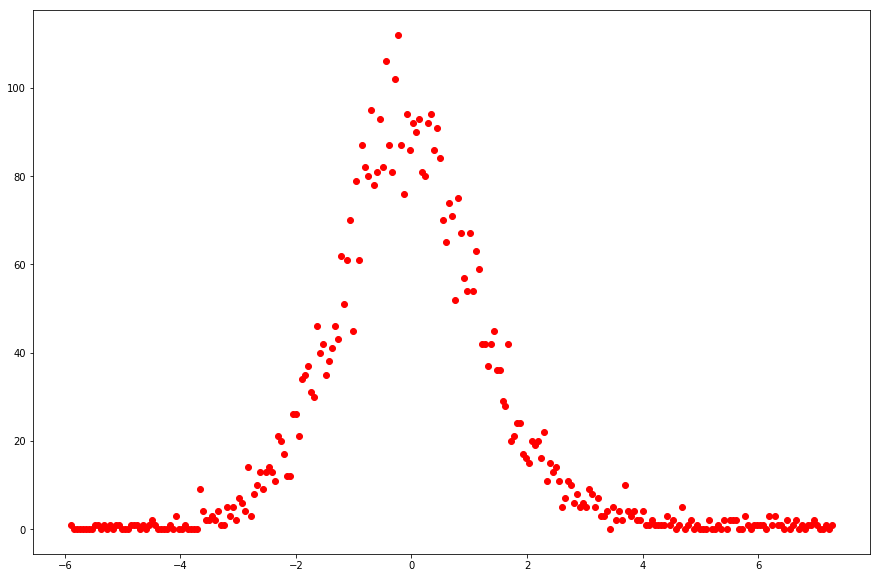

In [26]:
makeplots(np.array(Y_pig), np.array(Y_one_horse))

x
y


([<Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>],
  <matplotlib.axes._subplots.AxesSubplot at 0x1a2ef3f208>])

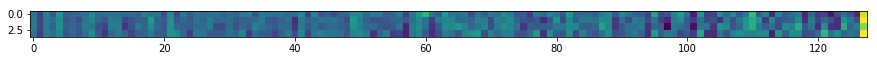

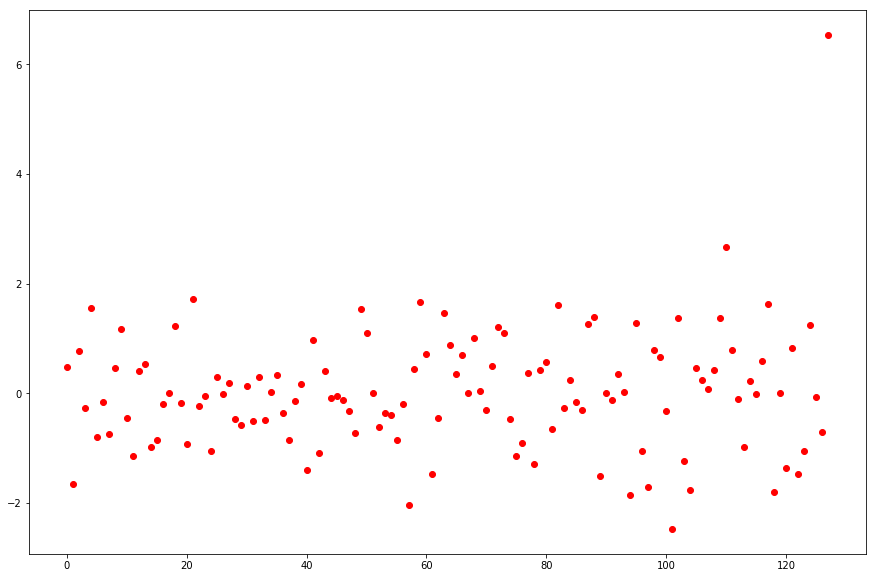

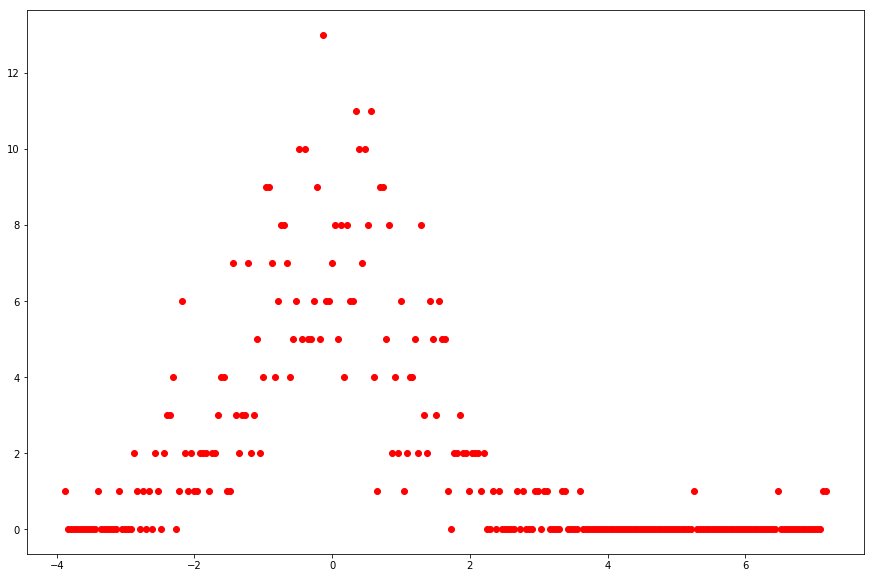

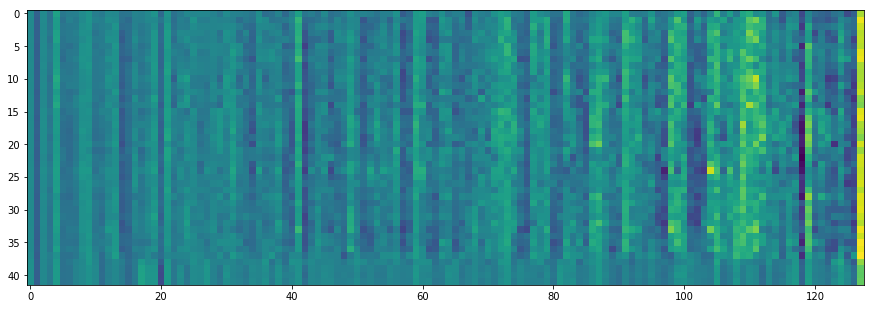

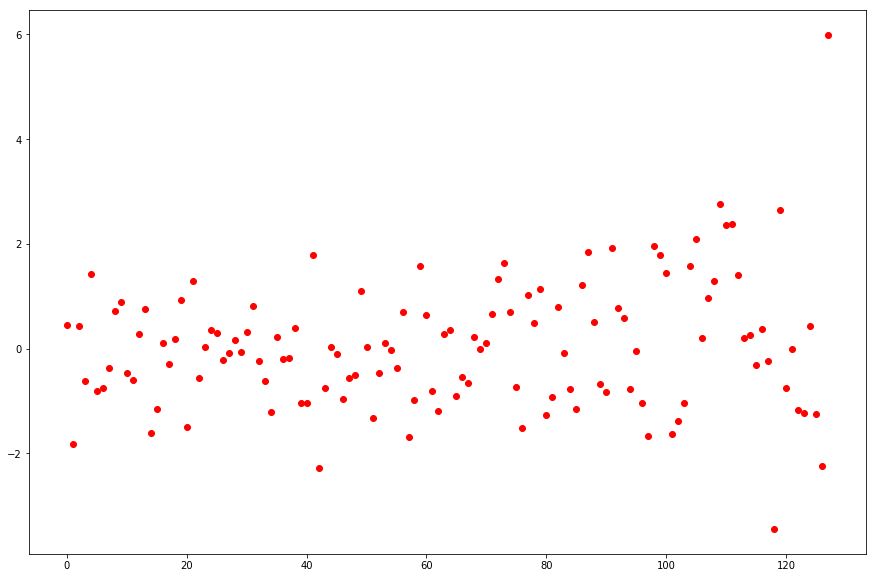

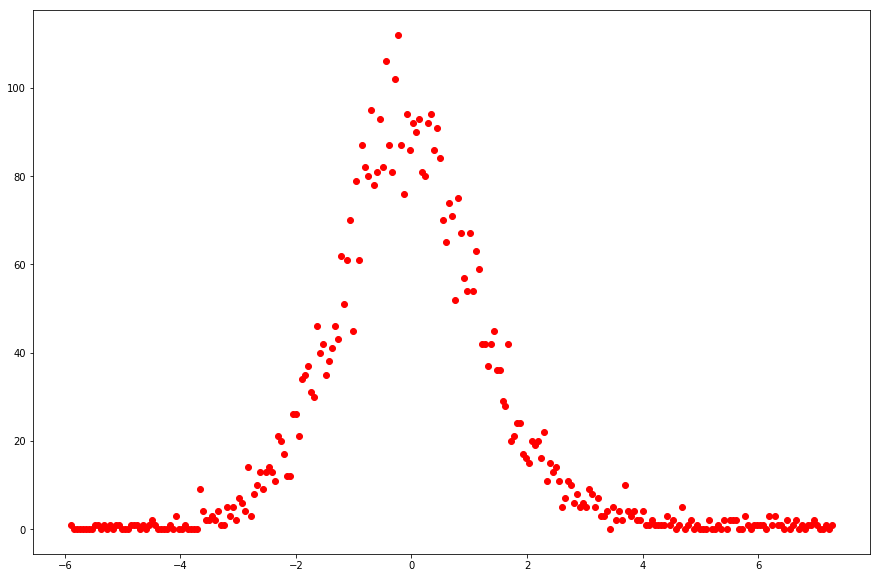

In [27]:
makeplots(np.array(Y_goat), np.array(Y_one_horse))

In [28]:
np.array(Y_one_horse_median)[np.newaxis,:].shape

(1, 128)

x
y


([<Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>],
  <matplotlib.axes._subplots.AxesSubplot at 0x1a2ee02d30>])

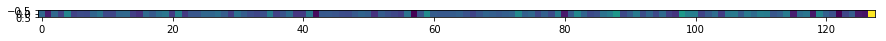

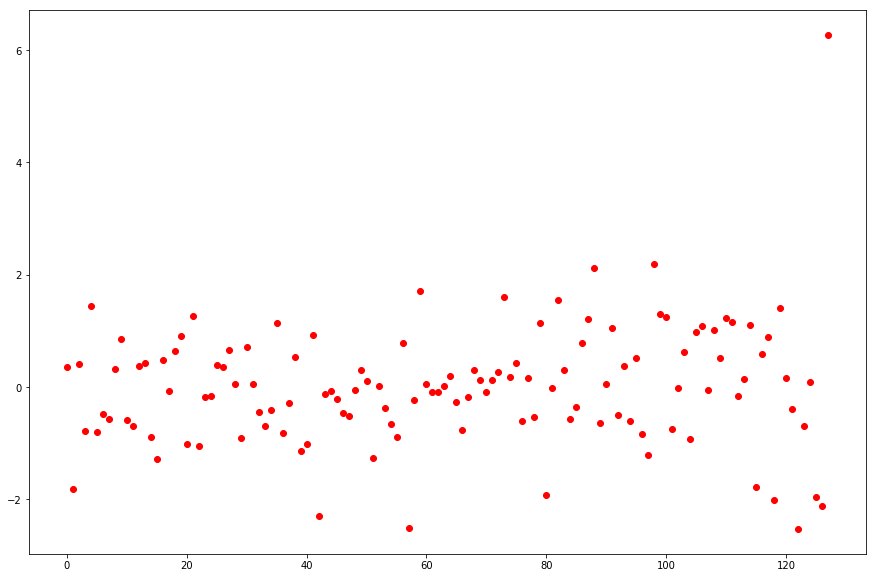

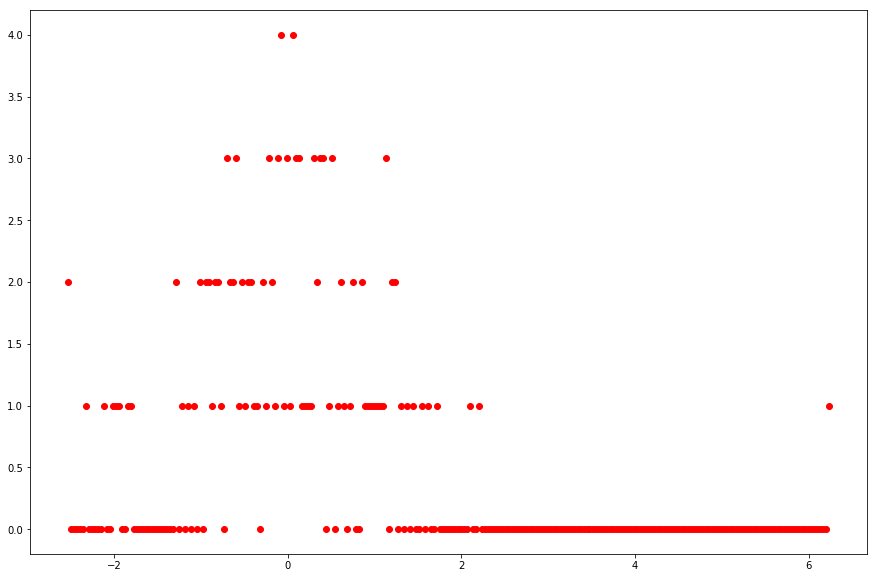

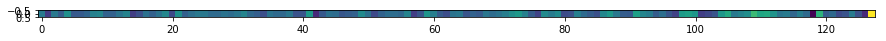

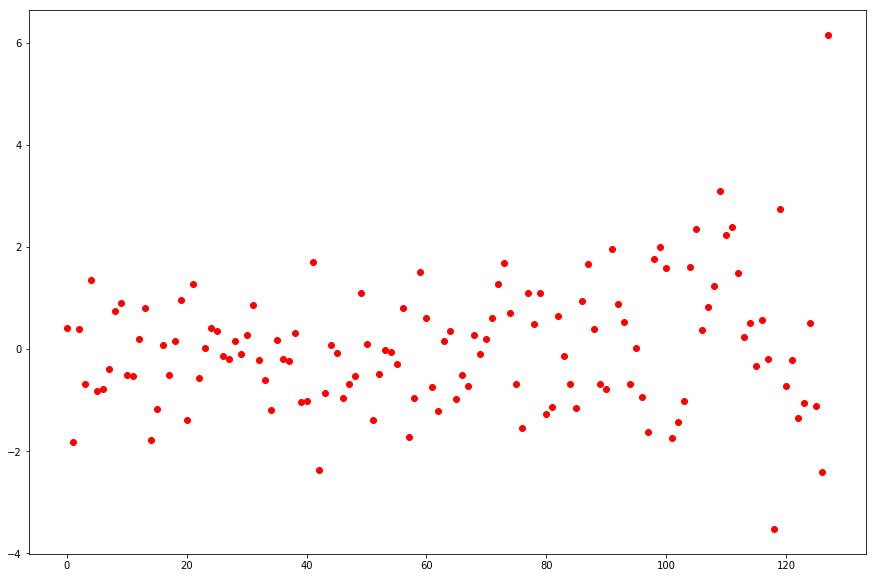

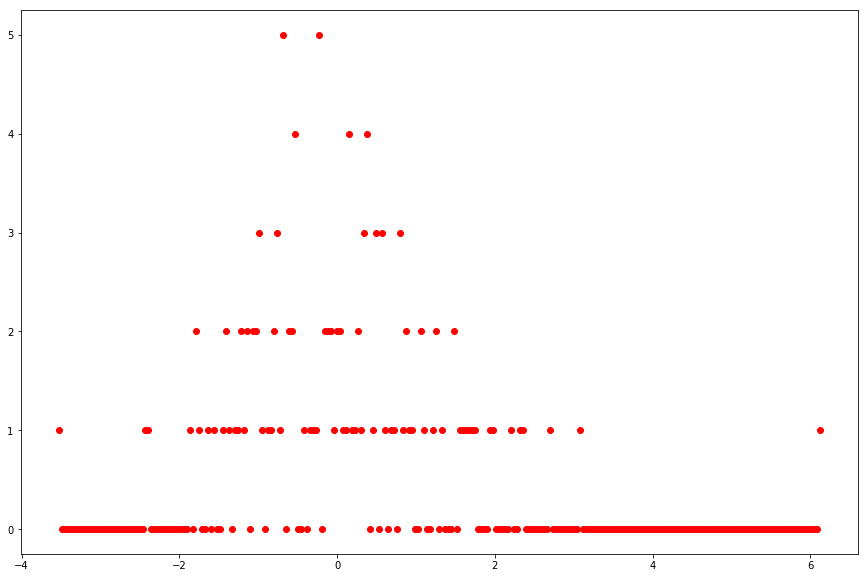

In [29]:
makeplots(np.array(Y_pig_median)[np.newaxis,:], np.array(Y_one_horse_median)[np.newaxis,:])

In [30]:
audio_feat.shape

(1, 128)

x
y


([<Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>],
  <matplotlib.axes._subplots.AxesSubplot at 0x1a3787ef28>])

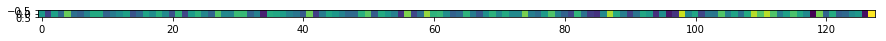

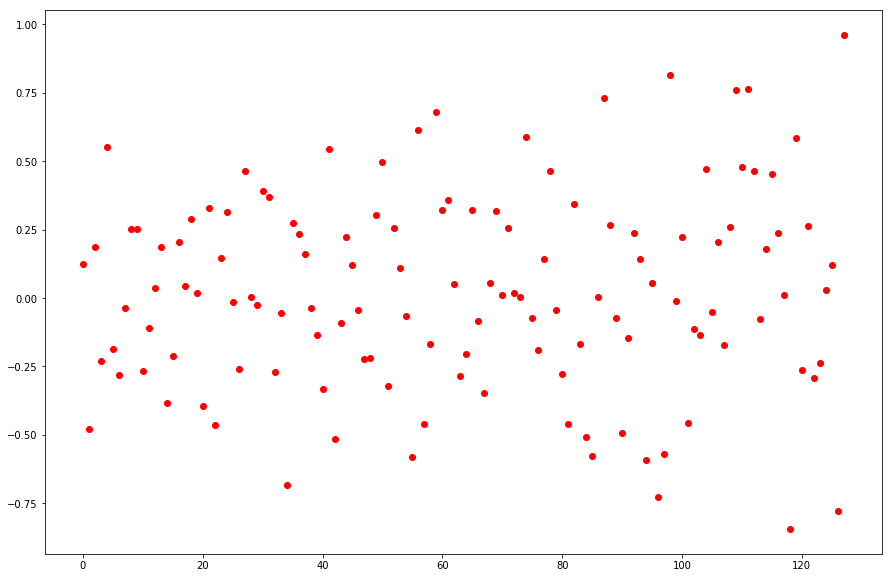

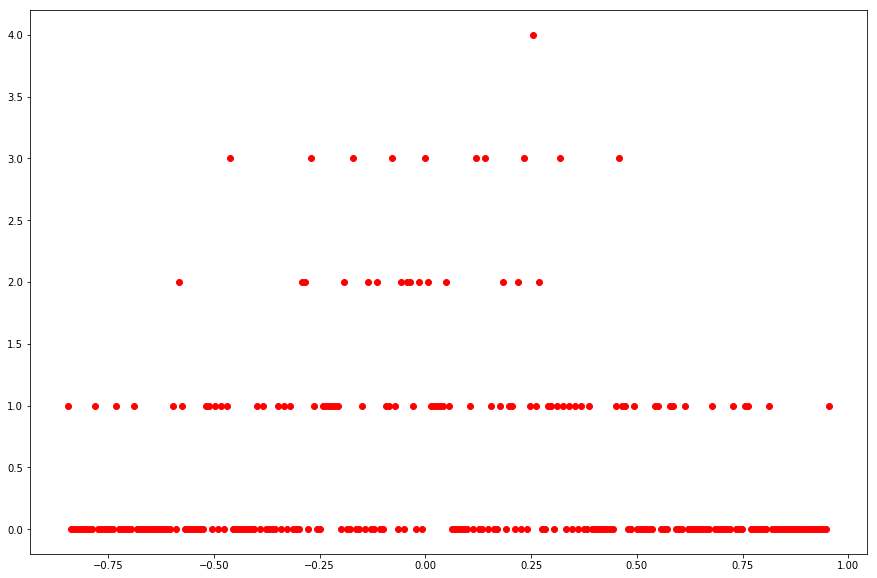

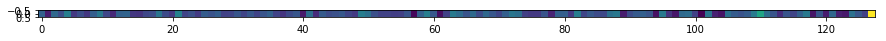

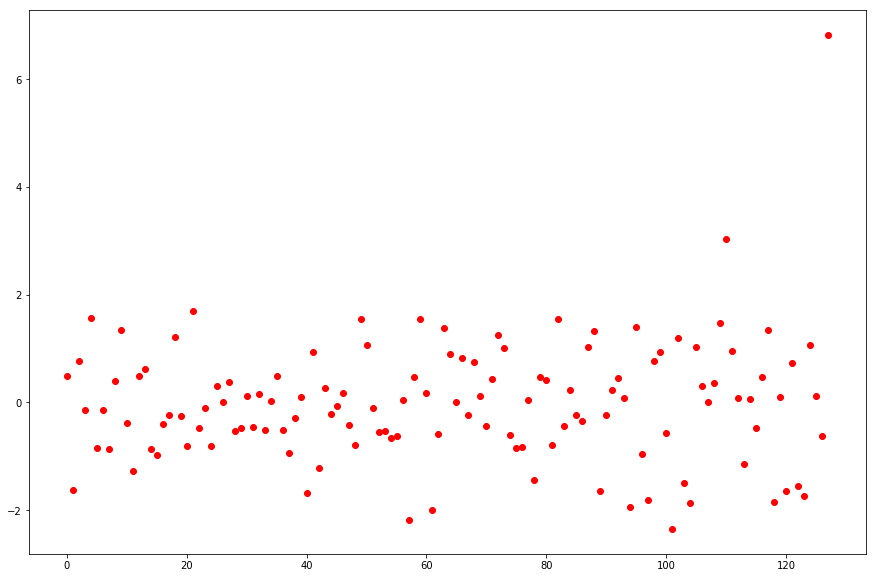

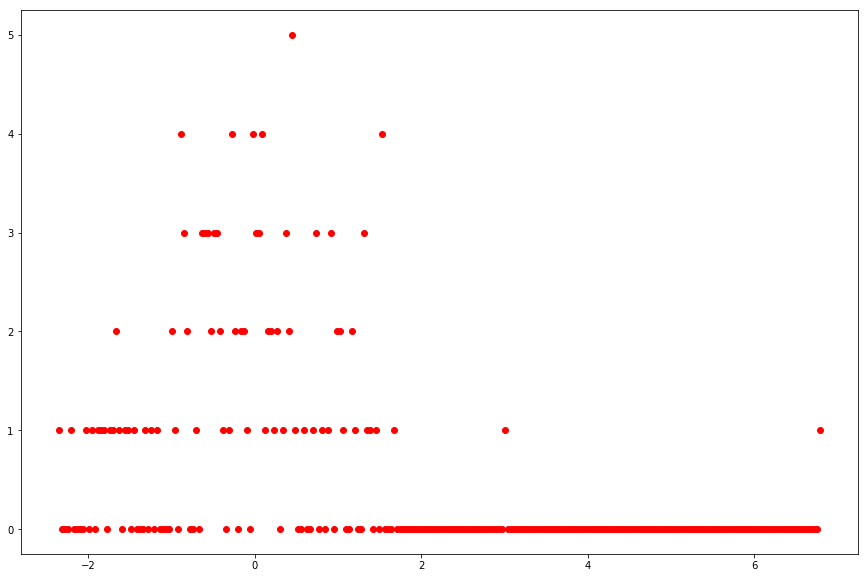

In [31]:
makeplots(audio_feat, np.array(Y_goat_median)[np.newaxis,:])

IndexError: tuple index out of range

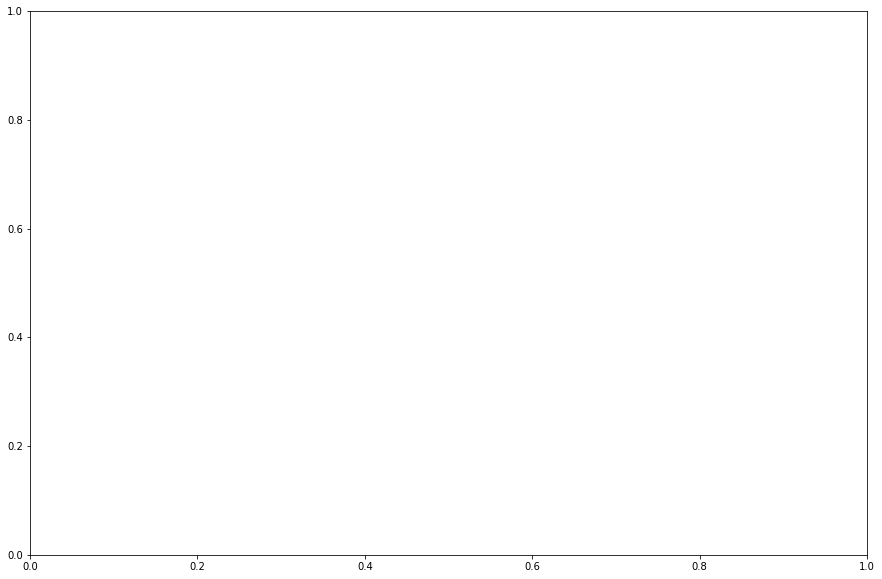

In [32]:
fig, ax = plt.subplots(figsize=(15,10))
x = np.array(Y_pig_median)
y = np.array(Y_one_horse_median)

ax.plot(np.arange(x.shape[1]), x, 'r0', np.arange(y.shape[1]), y, 'b+')